<h1><center>Basics of Algorithmic Trading</center></h1>

# Logistic Regression for Market Movement Prediction

Logistic model (or logit model) is used to model the probability of a certain class or event, such as pass/fail or win/lose. It is the go-to method for binary classification problems (problems with two class values).

# Setup

In [1]:
import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn. metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

# Read the data from local drive

In [2]:
data = pd.HDFStore('data/BitcoinPriceData.h5', 'r')

dataLog = data['BitcoinPriceData']

data.close()

print(dataLog.info())
print('-'*20)
print('-'*20)
print(dataLog.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2016-01-01 to 2021-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB
None
--------------------
--------------------
               Value
Date                
2021-05-29  35689.62
2021-05-30  34647.67
2021-05-31  35684.59
2021-06-01  37310.54
2021-06-02  36662.64


In [3]:
dataLog.rename(columns={'Value':'price'}, inplace=True)

# Logistic Regression

In [4]:
# Returns (log scale).
dataLog['returns'] = np.log(dataLog['price'] / dataLog['price'].shift(1))

dataLog.dropna(inplace=True)

In [5]:
# Last 'lags' days returns (log scale).
lags = 7

cols = [] 
for lag in range(1, lags + 1): 
  col = f'lag_{lag}'
  dataLog[col] = dataLog['returns'].shift(lag) 
  cols.append(col)

dataLog.dropna(inplace=True)

dataLog.tail()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,
2021-05-29,35689.62,-0.074376,-0.021124,0.022029,-0.008247,0.108268,-0.076785,0.006629,-0.089831
2021-05-30,34647.67,-0.029629,-0.074376,-0.021124,0.022029,-0.008247,0.108268,-0.076785,0.006629
2021-05-31,35684.59,0.029488,-0.029629,-0.074376,-0.021124,0.022029,-0.008247,0.108268,-0.076785
2021-06-01,37310.54,0.044557,0.029488,-0.029629,-0.074376,-0.021124,0.022029,-0.008247,0.108268
2021-06-02,36662.64,-0.017518,0.044557,0.029488,-0.029629,-0.074376,-0.021124,0.022029,-0.008247


In [6]:
dataLog.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,
2016-01-09,452.64,0.012449,-0.014810,0.048038,0.001226,-0.002544,0.000554,-0.002723,0.003717
2016-01-10,446.24,-0.014240,0.012449,-0.014810,0.048038,0.001226,-0.002544,0.000554,-0.002723
2016-01-11,447.11,0.001948,-0.014240,0.012449,-0.014810,0.048038,0.001226,-0.002544,0.000554
2016-01-12,447.98,0.001944,0.001948,-0.014240,0.012449,-0.014810,0.048038,0.001226,-0.002544
2016-01-13,429.57,-0.041964,0.001944,0.001948,-0.014240,0.012449,-0.014810,0.048038,0.001226


In [7]:
# Divide the dataset into training and test dataset.
cutoff = '2021-04-01'

# Training data.
training_data = dataLog[dataLog.index < cutoff].copy()

# Test data.
test_data = dataLog[dataLog.index >= cutoff].copy()

In [8]:
# Model.
lm = linear_model.LogisticRegression(C = 1e7, 
                                     solver = 'lbfgs', 
                                     multi_class = 'auto', 
                                     max_iter = 1000)

In [9]:
# Fit the model.
lm.fit(training_data[cols], np.sign(training_data['returns']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [10]:
# Predicted preferred position.
test_data['prediction'] = lm.predict(test_data[cols])

In [11]:
test_data.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,prediction
Date,,,,,,,,,,
2021-04-01,58735.25,0.000087,0.018950,0.032521,-0.001437,0.014233,0.068738,-0.021022,-0.036817,1.0
2021-04-02,58736.92,0.000028,0.000087,0.018950,0.032521,-0.001437,0.014233,0.068738,-0.021022,1.0
2021-04-03,59031.32,0.005000,0.000028,0.000087,0.018950,0.032521,-0.001437,0.014233,0.068738,1.0
2021-04-04,57076.49,-0.033676,0.005000,0.000028,0.000087,0.018950,0.032521,-0.001437,0.014233,1.0
2021-04-05,58206.55,0.019606,-0.033676,0.005000,0.000028,0.000087,0.018950,0.032521,-0.001437,1.0


In [12]:
# Accuracy.
accuracy_score(test_data['prediction'], np.sign(test_data['returns']))

0.5238095238095238

In [13]:
# Strategy based returns (log scale).
test_data['strategy'] = test_data['prediction'] * test_data['returns']

In [14]:
# Final returns based on the passive benchmark investment and strategy (regular scale).
returns = test_data[['returns', 'strategy']].sum().apply(np.exp)

returns

returns     0.624256
strategy    1.341854
dtype: float64

In [15]:
# Cumulative returns over time based on the passive benchmark investment and strategy (regular scale).
gross_performance_lg = test_data[['returns', 'strategy']].cumsum().apply(np.exp) 

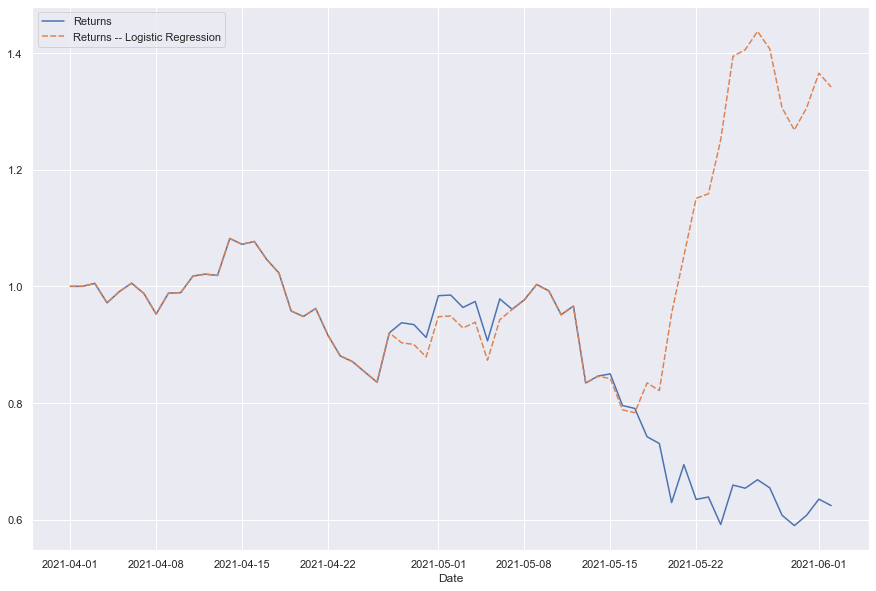

In [16]:
# Plot of cumulative returns based on the passive benchmark investment and strategy over time (regular scale).
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=gross_performance_lg, legend=False)
ax.legend(['Returns', 'Returns -- Logistic Regression'])
plt.show()

In [17]:
# Trades executed.
trades_lg = test_data['prediction'].diff().fillna(0) != 0

trades_lg.tail()

Date
2021-05-29    False
2021-05-30    False
2021-05-31    False
2021-06-01    False
2021-06-02    False
Name: prediction, dtype: bool

In [18]:
# Amount invested (US$).
amount_lg = 10000
# Transaction cost (constant) (log scale).
transaction_cost_lg = 0.1/100

# Subtract the transaction cost.
test_data['strategy'][trades_lg] -= transaction_cost_lg 

# Cumulative returns (US$).
test_data['creturns'] = amount_lg * test_data['returns'].cumsum().apply(np.exp)
test_data['cstrategy'] = amount_lg * test_data['strategy'].cumsum().apply(np.exp)

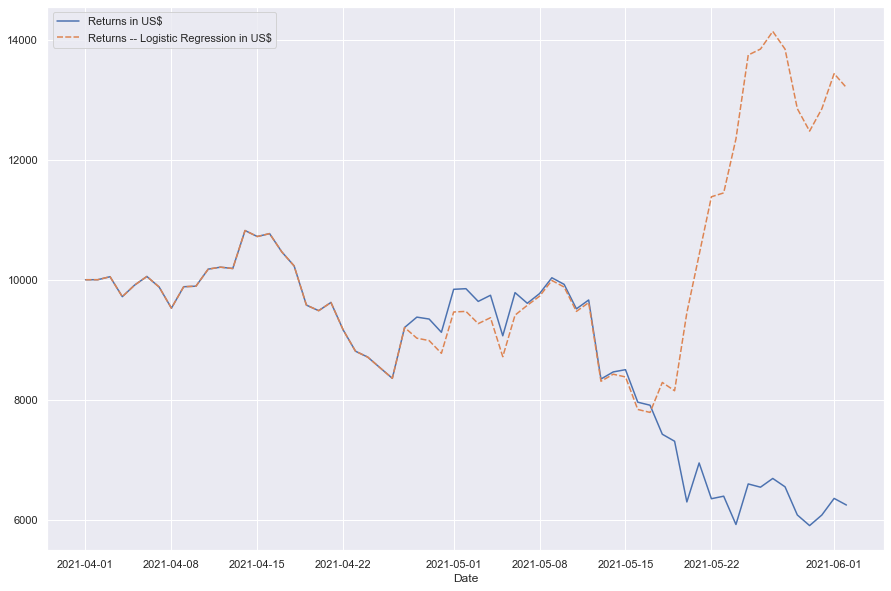

In [19]:
# Plot of cumulative returns.
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=test_data[['creturns', 'cstrategy']], legend=False)
ax.legend(['Returns in US$', 'Returns -- Logistic Regression in US$'])
plt.show()

## Summary

Applying sophisticated machine learning techniques to stock market prediction often yields promising results early on. In several examples, the strategies backtested outperform the base instrument significantly. But if the model is not updated after regular intervals of time, the performance of the considered strategy “suddenly” trails the base instrument or turns to a net loss.

### References

N/A